Build CNN:
- import libraries
- Load and normalize data
- OHEC data
- Split data into training and test
- Build CNN class with layers
- Evaluate model
- Tune hyper params
- Improve model and see what can be done better


The basic steps to build an image classification model using a neural network are:

- Flatten the input image dimensions to 1D (width pixels x height pixels)
- Normalize the image pixel values (divide by 255)
- One-Hot Encode the categorical column
- Build a model architecture (Sequential) with Dense layers
- Train the model and make predictions

In [ ]:
import pickle as pkl
import numpy as np
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class ConfigureDataset(Dataset):
    def __init__(self, X_Train, Y_Train, transform=None):
        self.X_Train = X_Train
        self.Y_Train = Y_Train
        self.transform = transform

    def __len__(self):
        return len(self.X_Train)

    def __getitem__(self, idx):
        x = self.X_Train[idx]
        y = self.Y_Train[idx]

        if self.transform:
            x = self.transform(x)

        return x, y

In [ ]:
# converts labels from an array of 36 to a value between 0 nd 259
def convert_label(label):
    numl = label[:10]
    letter = label[10:]
    return 26 * np.where(numl == 1)[0][0] + np.where(letter == 1)[0][0]


In [ ]:
file = open('../images_l.pkl', 'rb')
X_data = pkl.load(file)
file.close()

file = open('../labels_l.pkl', 'rb')
Y_data = pkl.load(file)
file.close()

file = open('../images_test.pkl', 'rb')
X_test_data = pkl.load(file)
file.close()

Y_data_2 = []
print(Y_data[:10])
for idx in range(len(Y_data)):
    Y_data_2.append(convert_label(Y_data[idx]))
print(Y_data_2[:10])

X_train = X_data[:25000]
Y_train = Y_data_2[:25000]

X_test = X_data[25000:]
Y_test = Y_data_2[25000:]

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0.

In [ ]:
print(type(X_train[0][0][0]))

<class 'numpy.float64'>


In [ ]:
train_set = ConfigureDataset(X_train, Y_train, transform=transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(), transforms.Normalize(12.2904, 48.2189)]))
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

In [ ]:
test_set = ConfigureDataset(X_test, Y_test, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(), transforms.Normalize(12.2904, 48.2189)]))
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [ ]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        # Mean over batch, height and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1

    mean = channels_sum / num_batches

    # std = sqrt(E[X^2] - (E[X])^2)
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [ ]:
print(next(iter(train_loader))[0][0].mean())

tensor(-0.0381, dtype=torch.float64)


In [ ]:
print(get_mean_and_std(train_loader))
print(get_mean_and_std(test_loader))

(tensor([1.4850e-05], dtype=torch.float64), tensor([1.0000], dtype=torch.float64))
(tensor([0.0005], dtype=torch.float64), tensor([1.0017], dtype=torch.float64))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


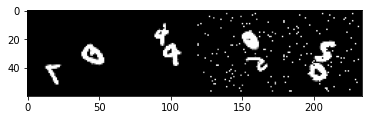

IndexError: ignored

In [ ]:
import matplotlib.pyplot as plt
import torchvision
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# print(images)
# print(labels)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % convert_label(labels[j]) for j in range(8)))

In [ ]:
# Define a convolutional neural network

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 128, 5),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(128, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(256, 256, 3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.full_layer_1 = nn.Sequential(
            nn.Linear(256 * 5 * 5, 1024),
            nn.ReLU()
        )

        self.output_layer = nn.Sequential(
            nn.Linear(1024, 260),
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = x.view(-1, 256 * 5 * 5)
        x = self.full_layer_1(x)
        x = self.output_layer(x)

        return x

net = Net().to(device)

In [ ]:
# Define a loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4, weight_decay=1e-5)#lr=0.01,momentum=0.9,lr=3e-4


In [ ]:
# test one set of images
# images and lables from image print cell
# zero the parameter gradients
optimizer.zero_grad()

images, labels = images.cuda(), labels.cuda()#when using gpu uncomment

# forward + backward + optimize
outputs = net(images.float())
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()

_, predicted = torch.max(outputs.data, 1)


In [ ]:
print(loss)
print(labels)
print(predicted)
print((predicted == labels).sum().item())

tensor(1.9780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([ 82,  43,  10, 232,  60, 226, 219, 209], device='cuda:0')
tensor([ 82, 199,  10, 232,  68, 226,  46, 162], device='cuda:0')
4


In [ ]:
# Train the network

for epoch in range(20):  # loop over the dataset multiple times
    net = net.float()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        inputs, labels = inputs.cuda(), labels.cuda()#when using gpu uncomment

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.192
[1,   100] loss: 0.077
[1,   150] loss: 0.088
[1,   200] loss: 0.110
[1,   250] loss: 0.102
[1,   300] loss: 0.138
[1,   350] loss: 0.176
[2,    50] loss: 0.151
[2,   100] loss: 0.139
[2,   150] loss: 0.140
[2,   200] loss: 0.132
[2,   250] loss: 0.146
[2,   300] loss: 0.147
[2,   350] loss: 0.130
[3,    50] loss: 0.127
[3,   100] loss: 0.109
[3,   150] loss: 0.158
[3,   200] loss: 0.119
[3,   250] loss: 0.177
[3,   300] loss: 0.165
[3,   350] loss: 0.142
[4,    50] loss: 0.129
[4,   100] loss: 0.151
[4,   150] loss: 0.136
[4,   200] loss: 0.152
[4,   250] loss: 0.133
[4,   300] loss: 0.148
[4,   350] loss: 0.130
[5,    50] loss: 0.128
[5,   100] loss: 0.144
[5,   150] loss: 0.140
[5,   200] loss: 0.138
[5,   250] loss: 0.159
[5,   300] loss: 0.128
[5,   350] loss: 0.145
[6,    50] loss: 0.118
[6,   100] loss: 0.114
[6,   150] loss: 0.104
[6,   200] loss: 0.110
[6,   250] loss: 0.159
[6,   300] loss: 0.146
[6,   350] loss: 0.112
[7,    50] loss: 0.143
[7,   100] 

In [ ]:
print(list(net.parameters()))


In [ ]:
testiter = iter(test_loader)
images, labels = next(testiter)

images, labels = images.cuda(), labels.cuda()#uncomment when using gpu

outputs = net(images.float())
print(outputs.data)
_, predicted = torch.max(outputs.data, 1)
print(predicted)
print(labels)

tensor([[ -49.4871,  -73.8119,  -54.5307,  ...,  -36.3130,  -24.3237,
          -76.4200],
        [ -54.2828,  -53.1219,  -75.7499,  ...,  -53.3106,  -71.2955,
          -75.7771],
        [ -53.9507,  -46.9919,  -80.6832,  ...,  -62.7901,  -64.4932,
          -79.2082],
        ...,
        [ -68.8420,  -55.8142,  -86.3615,  ...,  -56.2817,  -50.3280,
          -54.1690],
        [ -76.0651,  -52.3765,  -83.4253,  ...,  -56.5461,  -55.8910,
          -14.2567],
        [ -84.3472,  -66.4941, -103.0310,  ...,  -72.8393,  -96.4112,
          -42.2177]], device='cuda:0')
tensor([256, 209, 221, 247, 204, 133,  97,  36,  45, 221, 236,  71, 238,  74,
        109, 104,  37, 122,  49,  28, 163,  47, 223,  67,  37,   7,  76,   7,
         73,  97, 118,  32, 141, 151, 167, 123, 259,   4, 250, 173,  47, 243,
         27, 230, 240, 188, 196, 149, 213, 169, 165, 204,  73,  85, 200,  64,
         56,  20,  94,  99, 131, 255, 259, 233], device='cuda:0')
tensor([256, 209, 221, 244, 204, 133,  97,  3

In [ ]:
# Let's see how the network performs on the whole test dataset

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data

        images, labels = images.cuda(), labels.cuda() #uncomment when using gpu

        outputs = net(images.float())
        # _, predicted = torch.topk(outputs, 2)
        _, predicted = torch.max(outputs.data, 1)

        total += len(labels)
        correct += (predicted == labels).sum().item()


In [ ]:
print(outputs.shape)
print(labels.shape)
print(total)
print(correct)

print(torch.max(outputs.data, 1))
print(labels)

print('Accuracy of the network on the 5000 test images: %d %%' % (
    100 * correct / total))

torch.Size([8, 260])
torch.Size([8])
5000
3512
torch.return_types.max(
values=tensor([ -8.1658, -10.6015,  -9.3646, -11.7322,  -7.9146, -20.9746, -13.0231,
        -12.9122], device='cuda:0'),
indices=tensor([ 85,  71,  15, 138, 111, 238, 184, 226], device='cuda:0'))
tensor([ 85,  71,  15, 138, 104, 238, 184, 226], device='cuda:0')
Accuracy of the network on the 5000 test images: 70 %


In [ ]:
# Save our trained model

PATH = '.\model_latest.pth'
torch.save({'model71_state_dict':net.state_dict()}, PATH)

In [ ]:
def decode_label(label):
    new_label = np.zeros(36).astype(np.float64)
    num_idx = label//26
    let_idx = label%26
    new_label[num_idx] = 1.
    new_label[10+let_idx] = 1.
    return new_label

Run the decoder on the test labels

In [ ]:
file = open('../images_test.pkl', 'rb')
X_test_data = pkl.load(file)
file.close()

In [ ]:
testing_set = ConfigureDataset(X_test_data, Y_test, transform=transforms.Compose([transforms.ToTensor(), transforms.RandomHorizontalFlip(), transforms.Normalize(12.2904, 48.2189)]))
testing_loader = DataLoader(testing_set, batch_size=64, shuffle=True)

In [ ]:
testing_loader

In [ ]:
import csv

header = ['Id', 'Category']

# open the file in the write mode
f = open('../csv_output1.csv', 'w')
# create the csv writer
writer = csv.writer(f)

i=0
with torch.no_grad():
    for data in testing_loader: #error here with index of testing_loader
        images, labels = data

        images, labels = images.cuda(), labels.cuda() #uncomment when using gpu

        outputs = net(images)#.float())
        # _, predicted = torch.topk(outputs, 2)
        _, predicted = torch.max(outputs.data, 1)

        #add predicted labels to the CSV file
        row = [i, predicted]
        # write a row to the csv file
        writer.writerow(row)
        i=i+1



# close the file
f.close()

TypeError: ignored